# Resolution Calculation using Covariance Matrix - pick E,q pairs

Instrument: ARCS
* Ei=1000
* Fermi chopper: 600 Hz
* T0: 120Hz

In [16]:
# some goodies
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import mcvine.cli
from mcvine_workflow.DGS import ARCS

In [2]:
import histogram.hdf as hh, histogram as H

In [3]:
workdir = '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/debug-Ricky/'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/debug-Ricky


## Inputs

### ARCS parameters

In [4]:
L_PM=11.61
R = 3.
L_PS=13.6
L_MS=L_PS-L_PM

In [5]:
print L_MS

1.99


### Sample

In [6]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 5.490700041, 5.490700041, 5.490700041, 90, 90, 90
 basis_vectors:
  - 5.490700041, 0, 0
  - 0, 5.490700041, 0
  - 0, 0, 5.490700041
 primitive_basis_vectors:
  - 0.0, 2.71526503565, 2.71526503565
  - 2.71526503565, 0.0, 2.71526503565
  - 2.71526503565, 2.71526503565, 0.0
excitations:
  - type: deltafunction
    hkl: -16/3.,-8/3.,8/3.
    E: 40.
    dE: 0.5
orientation:
 u: -1, 1, -1
 v: 2, 1, -1
shape: hollowCylinder in_radius="5./8*inch" out_radius="1.*inch" height="1.5*inch"
temperature: 100*K

Overwriting Si.yml


In [7]:
sample_yml = './Si.yml'

### ** Dynamics parameters

In [21]:
Ei = 1000

In [22]:
hkl0 = np.array([0.,-0.,0.])
hkl_dir = np.array([1,0,0]) # projection

### ** Other parameters

In [23]:
# scan
psimin = -5
psimax = 90.
dpsi = 1.

### Dynamic range
Use the following code to explore the dynamic range

In [24]:
from mcvine_workflow.singlextal import dynrange
from mcvine_workflow.sample import loadSampleYml
sample = loadSampleYml(sample_yml)
psilist = np.arange(psimin, psimax, 5*dpsi)
qaxis = np.arange(-100, 100, .02)

(-999.99540169066859, 999.89360342276393)

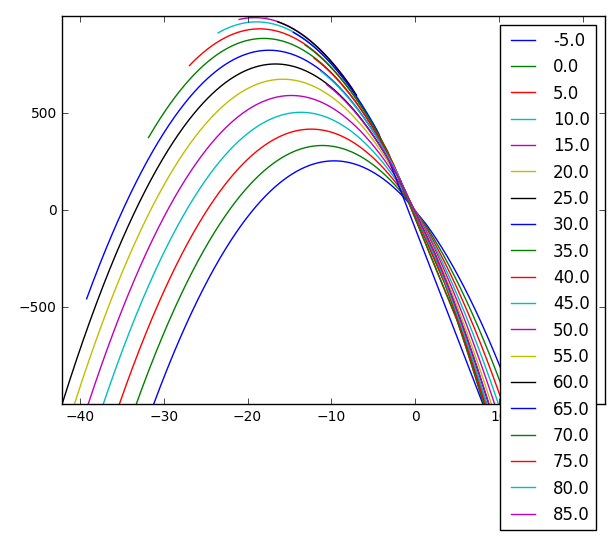

In [25]:
plt.figure(figsize=(7,5))
points_in_slice = list(dynrange.iterPointsInSlice(
        sample, psilist, Ei, hkl0, hkl_dir, qaxis,
        ARCS.scattering_angle_constraints,
        Erange=(-Ei, Ei)))
all_qs = np.concatenate([qs for _p, qs, _E in points_in_slice ])
qmin = np.min(all_qs); qmax = np.max(all_qs)

all_Es = np.concatenate([Es for _p, _q, Es in points_in_slice ])
Emin = np.min(all_Es); Emax = np.max(all_Es)

for psi, qs, Es in points_in_slice:
    plt.plot(qs, Es, label=str(psi))
    continue
    
plt.legend()
plt.xlim(qmin, qmax+(qmax-qmin)/5)
plt.ylim(Emin, Emax)

In [26]:
psilist = np.arange(psimin, psimax, dpsi)
points_in_slice = list(dynrange.iterPointsInSlice(
        sample, psilist, Ei, hkl0, hkl_dir, qaxis,
        ARCS.scattering_angle_constraints,
        Erange=(-Ei, Ei)))
all_qs = np.concatenate([qs for _p, qs, _E in points_in_slice ])
qmin = np.min(all_qs); qmax = np.max(all_qs)

all_Es = np.concatenate([Es for _p, _q, Es in points_in_slice ])
Emin = np.min(all_Es); Emax = np.max(all_Es)

In [27]:
fractions = [.9, .5, .25, 1./8, 1./16, 1./32, 1./64, 1./128]
Eq_pairs = []
for f in fractions:
    E = f*Ei
    print 'E=', E
    # find maximum Es smaller than E
    max_Es_smaller = np.max(all_Es[all_Es<E])
    # find minimum Es greater than E
    min_Es_greater = np.min(all_Es[all_Es>E])
    # print E, max_Es_smaller, min_Es_greater
    Ebracket = min(max_Es_smaller, E*.99), max(min_Es_greater, E*1.01)
    # get qs
    qs = all_qs[ (all_Es>=Ebracket[0])*(all_Es<=Ebracket[1]) ]
    # print len(qs)
    while len(qs) < 10:
        Ebracket = Ebracket[0]*.95, Ebracket[1]*1.05
        qs = all_qs[ (all_Es>=Ebracket[0])*(all_Es<=Ebracket[1]) ]
    print "Ebracket=", Ebracket, 'number of qs=', len(qs)
    Eq_pairs.append( (E, np.mean(qs)))
Eq_pairs = np.array(Eq_pairs)

E= 900.0
Ebracket= (891.0, 909.0) number of qs= 1585
E= 500.0
Ebracket= (495.0, 505.0) number of qs= 1128
E= 250.0
Ebracket= (247.5, 252.5) number of qs= 541
E= 125.0
Ebracket= (123.75, 126.25) number of qs= 126
E= 62.5
Ebracket= (61.875, 63.125) number of qs= 36
E= 31.25
Ebracket= (30.9375, 31.5625) number of qs= 20
E= 15.625
Ebracket= (14.6953125, 16.5703125) number of qs= 49
E= 7.8125
Ebracket= (7.3296608563634322, 8.28515625) number of qs= 21


In [28]:
print Ei
print Eq_pairs

1000
[[ 900.          -16.71530599]
 [ 500.          -12.83920213]
 [ 250.          -11.68957486]
 [ 125.          -15.52825397]
 [  62.5         -23.62444444]
 [  31.25        -27.068     ]
 [  15.625       -27.0955102 ]
 [   7.8125      -26.42761905]]
